In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import string, random
import pandas as pd
from keras.callbacks import EarlyStopping, ModelCheckpoint

prjectName = 'beans'
#Function that gets the test data 
def retrive_data():
    test_ds, info = tfds.load(prjectName, split='test', as_supervised=True, with_info=True, shuffle_files=True)
    print(info)
    # to see labels
    print(f'Classes:{info.features["label"].names}')
    # show the shape
    print(test_ds.element_spec)
    return test_ds, info

#Function that gets the training and validation data 
def get_training_data():
    validation_data = tfds.load(prjectName, split=f'validation', as_supervised=True)
    training_data = tfds.load(prjectName, split=f'train', as_supervised=True)
    return training_data, validation_data

def wrangle_data_GenPlus(dataset, split, batch_size=32):
    wrangled = dataset.map(lambda img, lbl: (tf.cast(img,tf.float32)/255.0,lbl))
    if split == 'train':
        features = np.array([x[0] for x in wrangled])
        lables = np.array([x[1] for x in wrangled])
        train_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
            horizontal_flip=True,
            zoom_range = 0.2,
            rotation_range=20,
            fill_mode='nearest'
        )
        wrangled = train_data_gen.flow(features, lables,batch_size=batch_size)
    elif split in ('valid','test' ) : # Caches the elements in this dataset. loat it into the memory to go faster
        wrangled = wrangled.cache()
        wrangled = wrangled.batch(batch_size)  # Combines consecutive elements of this dataset into batches.
        wrangled = wrangled.prefetch(tf.data.AUTOTUNE)
    return wrangled

def compileModel(model):
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.sparse_categorical_crossentropy,
                  # classification with integer encoded labels use "scce"
                  metrics=['accuracy'])
    print(model.summary())
    return model

relu = tf.keras.activations.relu
lrelu = lambda x: tf.keras.activations.relu(x, alpha=0.05)


def plot_History(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()


def run_model(model):
    # prepare the data
    train_ds, valid_ds = get_training_data()
    
    batch_size = 64
    train_data = wrangle_data_GenPlus(train_ds, 'train', batch_size=batch_size)
    valid_data = wrangle_data_GenPlus(valid_ds, 'valid', batch_size=batch_size)

    # fit the model
    earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')
    modelCheckpoint = ModelCheckpoint("best.model", save_best_only=True, monitor='val_loss', mode='min')
    history = model.fit(train_data, validation_data=valid_data, epochs=50, callbacks=[earlyStopping, modelCheckpoint])

    plot_History(history)


In [ ]:
# MODEL 1 No image resizing
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer((500, 500, 3)),
    tf.keras.layers.Conv2D(64, 3, activation=relu),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, 3, activation=relu),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, activation=relu),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, activation=relu),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, activation=relu),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation=relu),
    tf.keras.layers.Dense(128, activation=relu),
    tf.keras.layers.Dense(3, activation=tf.keras.activations.softmax)
], name='cnn_model')
model = compileModel(model)

run_model(model)

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 250, 250, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 248, 248, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 124, 124, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 59, 59, 128)       73

INFO:tensorflow:Assets written to: best.model/assets


17/17 [==============================] - 62s 3s/step - loss: 1.1035 - accuracy: 0.3878 - val_loss: 1.0609 - val_accuracy: 0.3459
Epoch 2/70
17/17 [==============================] - ETA: 0s - loss: 0.9792 - accuracy: 0.5087INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


17/17 [==============================] - 64s 4s/step - loss: 0.9792 - accuracy: 0.5087 - val_loss: 0.8856 - val_accuracy: 0.6241
Epoch 3/70
17/17 [==============================] - ETA: 0s - loss: 0.8729 - accuracy: 0.6180INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


17/17 [==============================] - 54s 3s/step - loss: 0.8729 - accuracy: 0.6180 - val_loss: 0.8187 - val_accuracy: 0.5639
Epoch 4/70
17/17 [==============================] - ETA: 0s - loss: 0.7873 - accuracy: 0.6567INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


17/17 [==============================] - 52s 3s/step - loss: 0.7873 - accuracy: 0.6567 - val_loss: 0.7443 - val_accuracy: 0.7068
Epoch 5/70
17/17 [==============================] - 52s 3s/step - loss: 0.8023 - accuracy: 0.6528 - val_loss: 0.7472 - val_accuracy: 0.6391
Epoch 6/70
17/17 [==============================] - 50s 3s/step - loss: 0.7535 - accuracy: 0.6547 - val_loss: 0.8062 - val_accuracy: 0.6090
Epoch 7/70
17/17 [==============================] - ETA: 0s - loss: 0.7316 - accuracy: 0.6838INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


17/17 [==============================] - 52s 3s/step - loss: 0.7316 - accuracy: 0.6838 - val_loss: 0.6336 - val_accuracy: 0.7218
Epoch 8/70
17/17 [==============================] - 51s 3s/step - loss: 0.6689 - accuracy: 0.7147 - val_loss: 0.6591 - val_accuracy: 0.7143
Epoch 9/70
17/17 [==============================] - ETA: 0s - loss: 0.6470 - accuracy: 0.7166INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


17/17 [==============================] - 53s 3s/step - loss: 0.6470 - accuracy: 0.7166 - val_loss: 0.5960 - val_accuracy: 0.7143
Epoch 10/70
17/17 [==============================] - ETA: 0s - loss: 0.5714 - accuracy: 0.7640INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


17/17 [==============================] - 52s 3s/step - loss: 0.5714 - accuracy: 0.7640 - val_loss: 0.4875 - val_accuracy: 0.7820
Epoch 11/70
17/17 [==============================] - ETA: 0s - loss: 0.5007 - accuracy: 0.7998INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


17/17 [==============================] - 52s 3s/step - loss: 0.5007 - accuracy: 0.7998 - val_loss: 0.4225 - val_accuracy: 0.8271
Epoch 12/70
17/17 [==============================] - 51s 3s/step - loss: 0.4867 - accuracy: 0.8008 - val_loss: 0.4640 - val_accuracy: 0.8271
Epoch 13/70
17/17 [==============================] - ETA: 0s - loss: 0.4312 - accuracy: 0.8230INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


17/17 [==============================] - 53s 3s/step - loss: 0.4312 - accuracy: 0.8230 - val_loss: 0.3847 - val_accuracy: 0.8346
Epoch 14/70
17/17 [==============================] - 51s 3s/step - loss: 0.4149 - accuracy: 0.8317 - val_loss: 0.3869 - val_accuracy: 0.8571
Epoch 15/70
17/17 [==============================] - ETA: 0s - loss: 0.4204 - accuracy: 0.8356INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


17/17 [==============================] - 52s 3s/step - loss: 0.4204 - accuracy: 0.8356 - val_loss: 0.2956 - val_accuracy: 0.8872
Epoch 16/70
17/17 [==============================] - 51s 3s/step - loss: 0.3641 - accuracy: 0.8627 - val_loss: 0.4211 - val_accuracy: 0.8346
Epoch 17/70
17/17 [==============================] - 50s 3s/step - loss: 0.3526 - accuracy: 0.8511 - val_loss: 0.3193 - val_accuracy: 0.8571
Epoch 18/70
17/17 [==============================] - ETA: 0s - loss: 0.3242 - accuracy: 0.8772INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


17/17 [==============================] - 52s 3s/step - loss: 0.3242 - accuracy: 0.8772 - val_loss: 0.2000 - val_accuracy: 0.9398
Epoch 19/70
17/17 [==============================] - 51s 3s/step - loss: 0.2929 - accuracy: 0.8772 - val_loss: 0.2820 - val_accuracy: 0.8947
Epoch 20/70
17/17 [==============================] - ETA: 0s - loss: 0.3315 - accuracy: 0.8617INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


17/17 [==============================] - 52s 3s/step - loss: 0.3315 - accuracy: 0.8617 - val_loss: 0.1791 - val_accuracy: 0.9474
Epoch 21/70
17/17 [==============================] - 51s 3s/step - loss: 0.3676 - accuracy: 0.8549 - val_loss: 0.2556 - val_accuracy: 0.8947
Epoch 22/70
17/17 [==============================] - 50s 3s/step - loss: 0.2935 - accuracy: 0.8810 - val_loss: 0.2381 - val_accuracy: 0.9098
Epoch 23/70
17/17 [==============================] - 51s 3s/step - loss: 0.2825 - accuracy: 0.8810 - val_loss: 0.1971 - val_accuracy: 0.9699
Epoch 24/70
17/17 [==============================] - 51s 3s/step - loss: 0.2662 - accuracy: 0.8956 - val_loss: 0.2617 - val_accuracy: 0.9173
Epoch 25/70
17/17 [==============================] - ETA: 0s - loss: 0.2386 - accuracy: 0.9101INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


17/17 [==============================] - 52s 3s/step - loss: 0.2386 - accuracy: 0.9101 - val_loss: 0.1772 - val_accuracy: 0.9398
Epoch 26/70
17/17 [==============================] - 50s 3s/step - loss: 0.2585 - accuracy: 0.9052 - val_loss: 0.2520 - val_accuracy: 0.9248
Epoch 27/70
17/17 [==============================] - 50s 3s/step - loss: 0.2730 - accuracy: 0.8956 - val_loss: 0.2647 - val_accuracy: 0.9098
Epoch 28/70
17/17 [==============================] - ETA: 0s - loss: 0.2580 - accuracy: 0.9004INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


17/17 [==============================] - 52s 3s/step - loss: 0.2580 - accuracy: 0.9004 - val_loss: 0.1535 - val_accuracy: 0.9474
Epoch 29/70
17/17 [==============================] - 67s 4s/step - loss: 0.2317 - accuracy: 0.9033 - val_loss: 0.1621 - val_accuracy: 0.9248
Epoch 30/70
17/17 [==============================] - 63s 4s/step - loss: 0.2171 - accuracy: 0.9178 - val_loss: 0.1607 - val_accuracy: 0.9398
Epoch 31/70
17/17 [==============================] - 55s 3s/step - loss: 0.1994 - accuracy: 0.9304 - val_loss: 0.1920 - val_accuracy: 0.9398
Epoch 32/70
17/17 [==============================] - ETA: 0s - loss: 0.1589 - accuracy: 0.9362INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


17/17 [==============================] - 57s 3s/step - loss: 0.1589 - accuracy: 0.9362 - val_loss: 0.1392 - val_accuracy: 0.9624
Epoch 33/70
17/17 [==============================] - 50s 3s/step - loss: 0.1645 - accuracy: 0.9420 - val_loss: 0.2417 - val_accuracy: 0.9173
Epoch 34/70
17/17 [==============================] - 51s 3s/step - loss: 0.2247 - accuracy: 0.9101 - val_loss: 0.1982 - val_accuracy: 0.9474
Epoch 35/70
17/17 [==============================] - 50s 3s/step - loss: 0.1574 - accuracy: 0.9458 - val_loss: 0.2532 - val_accuracy: 0.9398
Epoch 36/70
17/17 [==============================] - 51s 3s/step - loss: 0.1730 - accuracy: 0.9226 - val_loss: 0.1843 - val_accuracy: 0.9323
Epoch 37/70
17/17 [==============================] - 50s 3s/step - loss: 0.1556 - accuracy: 0.9410 - val_loss: 0.2752 - val_accuracy: 0.8872


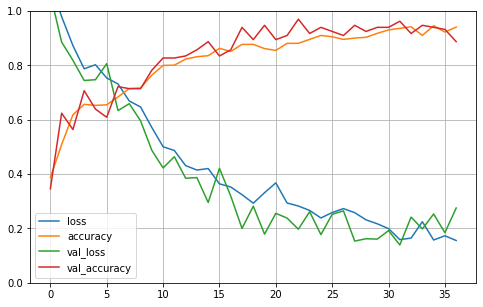

NameError: ignored

In [ ]:
# MODEL 2 Resize to 250x250 instead of 125x125
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer((500, 500, 3)),
    tf.keras.layers.experimental.preprocessing.Resizing(250,250),
    tf.keras.layers.Conv2D(64, 3, activation=relu),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, 3, activation=relu),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, activation=relu),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, activation=relu),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, activation=relu),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation=relu),
    tf.keras.layers.Dense(128, activation=relu),
    tf.keras.layers.Dense(3, activation=tf.keras.activations.softmax)
], name='cnn_model')
model = compileModel(model)

run_model(model)

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 250, 250, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 248, 248, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 124, 124, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 59, 59, 128)       73

INFO:tensorflow:Assets written to: best.model/assets


17/17 [==============================] - 61s 3s/step - loss: 1.1084 - accuracy: 0.3182 - val_loss: 1.0822 - val_accuracy: 0.4361
Epoch 2/50
17/17 [==============================] - ETA: 0s - loss: 1.0481 - accuracy: 0.4565INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


17/17 [==============================] - 52s 3s/step - loss: 1.0481 - accuracy: 0.4565 - val_loss: 0.9772 - val_accuracy: 0.4737
Epoch 3/50
17/17 [==============================] - ETA: 0s - loss: 0.9005 - accuracy: 0.5909INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


17/17 [==============================] - 52s 3s/step - loss: 0.9005 - accuracy: 0.5909 - val_loss: 0.8162 - val_accuracy: 0.6767
Epoch 4/50
17/17 [==============================] - ETA: 0s - loss: 0.9028 - accuracy: 0.5880INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


17/17 [==============================] - 52s 3s/step - loss: 0.9028 - accuracy: 0.5880 - val_loss: 0.8045 - val_accuracy: 0.6241
Epoch 5/50
17/17 [==============================] - ETA: 0s - loss: 0.8221 - accuracy: 0.6344INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


17/17 [==============================] - 52s 3s/step - loss: 0.8221 - accuracy: 0.6344 - val_loss: 0.7885 - val_accuracy: 0.6541
Epoch 6/50
17/17 [==============================] - ETA: 0s - loss: 0.8098 - accuracy: 0.6412INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


17/17 [==============================] - 52s 3s/step - loss: 0.8098 - accuracy: 0.6412 - val_loss: 0.7164 - val_accuracy: 0.6992
Epoch 7/50
17/17 [==============================] - ETA: 0s - loss: 0.7505 - accuracy: 0.6876INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


17/17 [==============================] - 52s 3s/step - loss: 0.7505 - accuracy: 0.6876 - val_loss: 0.6752 - val_accuracy: 0.7218
Epoch 8/50
17/17 [==============================] - ETA: 0s - loss: 0.6899 - accuracy: 0.7031INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


17/17 [==============================] - 51s 3s/step - loss: 0.6899 - accuracy: 0.7031 - val_loss: 0.6727 - val_accuracy: 0.6917
Epoch 9/50
17/17 [==============================] - ETA: 0s - loss: 0.6142 - accuracy: 0.7466INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


17/17 [==============================] - 52s 3s/step - loss: 0.6142 - accuracy: 0.7466 - val_loss: 0.5036 - val_accuracy: 0.8346
Epoch 10/50
17/17 [==============================] - 50s 3s/step - loss: 0.6820 - accuracy: 0.7108 - val_loss: 0.6232 - val_accuracy: 0.6992
Epoch 11/50
17/17 [==============================] - 50s 3s/step - loss: 0.6205 - accuracy: 0.7205 - val_loss: 0.5480 - val_accuracy: 0.7594
Epoch 12/50
17/17 [==============================] - 50s 3s/step - loss: 0.5741 - accuracy: 0.7640 - val_loss: 0.5376 - val_accuracy: 0.8120
Epoch 13/50
17/17 [==============================] - ETA: 0s - loss: 0.5455 - accuracy: 0.7708INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


17/17 [==============================] - 52s 3s/step - loss: 0.5455 - accuracy: 0.7708 - val_loss: 0.4855 - val_accuracy: 0.8120
Epoch 14/50
17/17 [==============================] - ETA: 0s - loss: 0.5944 - accuracy: 0.7466INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


17/17 [==============================] - 52s 3s/step - loss: 0.5944 - accuracy: 0.7466 - val_loss: 0.4470 - val_accuracy: 0.8421
Epoch 15/50
17/17 [==============================] - ETA: 0s - loss: 0.4913 - accuracy: 0.8008INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


17/17 [==============================] - 52s 3s/step - loss: 0.4913 - accuracy: 0.8008 - val_loss: 0.3671 - val_accuracy: 0.8872
Epoch 16/50
17/17 [==============================] - 50s 3s/step - loss: 0.5182 - accuracy: 0.7921 - val_loss: 0.4188 - val_accuracy: 0.8421
Epoch 17/50
17/17 [==============================] - 50s 3s/step - loss: 0.5367 - accuracy: 0.7708 - val_loss: 0.4411 - val_accuracy: 0.8195
Epoch 18/50
17/17 [==============================] - 50s 3s/step - loss: 0.4040 - accuracy: 0.8356 - val_loss: 0.4048 - val_accuracy: 0.8346
Epoch 19/50
17/17 [==============================] - 50s 3s/step - loss: 0.3842 - accuracy: 0.8356 - val_loss: 0.4215 - val_accuracy: 0.7820
Epoch 20/50
17/17 [==============================] - 50s 3s/step - loss: 0.3773 - accuracy: 0.8424 - val_loss: 0.4189 - val_accuracy: 0.7669


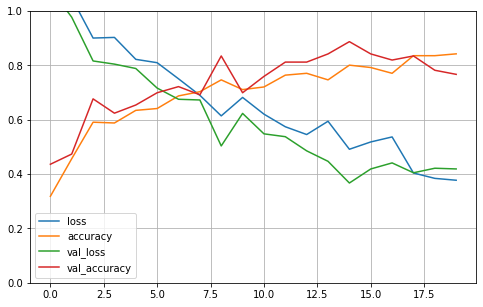

In [ ]:
# MODEL 3 Resize to 250x250 instead of 125x125, and use LReLU with alpha=0.05 instead of ReLU
lrelu = lambda x: tf.keras.activations.relu(x, alpha=0.05)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer((500, 500, 3)),
    tf.keras.layers.experimental.preprocessing.Resizing(250,250),
    tf.keras.layers.Conv2D(64, 3, activation=lrelu),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, 3, activation=lrelu),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, activation=lrelu),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, activation=lrelu),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, activation=lrelu),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation=lrelu),
    tf.keras.layers.Dense(128, activation=lrelu),
    tf.keras.layers.Dense(3, activation=tf.keras.activations.softmax)
], name='cnn_model')
model = compileModel(model)

run_model(model)

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 250, 250, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 248, 248, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 124, 124, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 59, 59, 128)       73

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incompleteQQ1H0Q/beans-train.tfrecord


  0%|          | 0/1034 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incompleteQQ1H0Q/beans-validation.tfrecord


  0%|          | 0/133 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incompleteQQ1H0Q/beans-test.tfrecord


  0%|          | 0/128 [00:00<?, ? examples/s]

Dataset beans downloaded and prepared to /root/tensorflow_datasets/beans/0.1.0. Subsequent calls will reuse this data.
Epoch 1/50
17/17 [==============================] - ETA: 0s - loss: 1.0929 - accuracy: 0.3627INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


17/17 [==============================] - 61s 3s/step - loss: 1.0929 - accuracy: 0.3627 - val_loss: 1.0476 - val_accuracy: 0.4060
Epoch 2/50
17/17 [==============================] - ETA: 0s - loss: 0.9397 - accuracy: 0.5426INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


17/17 [==============================] - 49s 3s/step - loss: 0.9397 - accuracy: 0.5426 - val_loss: 0.8258 - val_accuracy: 0.6090
Epoch 3/50
17/17 [==============================] - ETA: 0s - loss: 0.8622 - accuracy: 0.5870INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


17/17 [==============================] - 48s 3s/step - loss: 0.8622 - accuracy: 0.5870 - val_loss: 0.7920 - val_accuracy: 0.5940
Epoch 4/50
17/17 [==============================] - 47s 3s/step - loss: 0.8531 - accuracy: 0.5832 - val_loss: 0.9410 - val_accuracy: 0.5789
Epoch 5/50
17/17 [==============================] - ETA: 0s - loss: 0.8801 - accuracy: 0.5967INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


17/17 [==============================] - 48s 3s/step - loss: 0.8801 - accuracy: 0.5967 - val_loss: 0.7743 - val_accuracy: 0.6165
Epoch 6/50
17/17 [==============================] - ETA: 0s - loss: 0.7585 - accuracy: 0.6489INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


17/17 [==============================] - 48s 3s/step - loss: 0.7585 - accuracy: 0.6489 - val_loss: 0.6805 - val_accuracy: 0.7068
Epoch 7/50
17/17 [==============================] - ETA: 0s - loss: 0.7042 - accuracy: 0.7070INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


17/17 [==============================] - 48s 3s/step - loss: 0.7042 - accuracy: 0.7070 - val_loss: 0.5943 - val_accuracy: 0.7519
Epoch 8/50
17/17 [==============================] - ETA: 0s - loss: 0.7005 - accuracy: 0.6847INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


17/17 [==============================] - 48s 3s/step - loss: 0.7005 - accuracy: 0.6847 - val_loss: 0.5469 - val_accuracy: 0.7820
Epoch 9/50
17/17 [==============================] - ETA: 0s - loss: 0.6227 - accuracy: 0.7186INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


17/17 [==============================] - 49s 3s/step - loss: 0.6227 - accuracy: 0.7186 - val_loss: 0.4923 - val_accuracy: 0.7970
Epoch 10/50
17/17 [==============================] - 48s 3s/step - loss: 0.6032 - accuracy: 0.7360 - val_loss: 0.5636 - val_accuracy: 0.7970
Epoch 11/50
17/17 [==============================] - ETA: 0s - loss: 0.5223 - accuracy: 0.7882INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


17/17 [==============================] - 52s 3s/step - loss: 0.5223 - accuracy: 0.7882 - val_loss: 0.4253 - val_accuracy: 0.8346
Epoch 12/50
17/17 [==============================] - 56s 3s/step - loss: 0.5017 - accuracy: 0.7776 - val_loss: 0.4538 - val_accuracy: 0.8271
Epoch 13/50
17/17 [==============================] - 49s 3s/step - loss: 0.4984 - accuracy: 0.7863 - val_loss: 0.4494 - val_accuracy: 0.8346
Epoch 14/50
17/17 [==============================] - ETA: 0s - loss: 0.4256 - accuracy: 0.8288INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


17/17 [==============================] - 49s 3s/step - loss: 0.4256 - accuracy: 0.8288 - val_loss: 0.2991 - val_accuracy: 0.8947
Epoch 15/50
17/17 [==============================] - ETA: 0s - loss: 0.3717 - accuracy: 0.8511INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets


17/17 [==============================] - 48s 3s/step - loss: 0.3717 - accuracy: 0.8511 - val_loss: 0.2421 - val_accuracy: 0.9098
Epoch 16/50
17/17 [==============================] - 48s 3s/step - loss: 0.3387 - accuracy: 0.8685 - val_loss: 0.3853 - val_accuracy: 0.8647
Epoch 17/50
17/17 [==============================] - 47s 3s/step - loss: 0.3607 - accuracy: 0.8569 - val_loss: 0.2910 - val_accuracy: 0.8872
Epoch 18/50
17/17 [==============================] - 47s 3s/step - loss: 0.3262 - accuracy: 0.8665 - val_loss: 0.3051 - val_accuracy: 0.8797
Epoch 19/50
17/17 [==============================] - 47s 3s/step - loss: 0.3218 - accuracy: 0.8646 - val_loss: 0.2598 - val_accuracy: 0.9098
Epoch 20/50
17/17 [==============================] - 47s 3s/step - loss: 0.2721 - accuracy: 0.8907 - val_loss: 0.3694 - val_accuracy: 0.9023


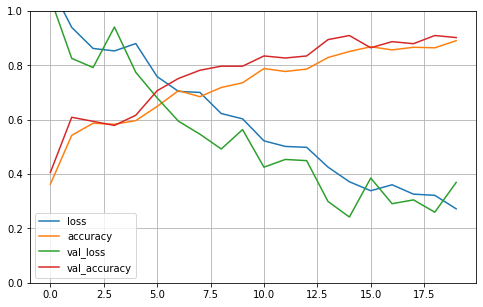

In [ ]:
# MODEL 4 Resize to 250x250 instead of 125x125, and use LReLU with alpha=0.1 instead of ReLU

lrelu = lambda x: tf.keras.activations.relu(x, alpha=0.1)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer((500, 500, 3)),
    tf.keras.layers.experimental.preprocessing.Resizing(250,250),
    tf.keras.layers.Conv2D(64, 3, activation=relu),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, 3, activation=relu),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, activation=relu),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, activation=relu),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, activation=relu),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation=relu),
    tf.keras.layers.Dense(128, activation=relu),
    tf.keras.layers.Dense(3, activation=tf.keras.activations.softmax)
], name='cnn_model')
model = compileModel(model)

run_model(model)

Uploadind a new bean leaf photo on the 4 model

In [ ]:
!pip install -Uq fastai

!pip install Pillow
import fastai
from fastai.vision import *

from fastai.vision.widgets import FileUpload, Output, Label

from PIL import Image

btn_upload = FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

Displaying the photo

In [ ]:
import io

img = Image.open(io.BytesIO(btn_upload.data[-1]))
out_pl = Output()
out_pl.clear_output()
with out_pl:display(img.to_thumb(128, 128))
out_pl

Output()

Predicting the label of the photo

In [ ]:
from keras.preprocessing import image

img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

y_probs = model.predict(img_tensor)[0]
y_class_idx = int(y_probs.argmax(axis=-1))

labels = ["Angular Leaf Spot", "Bean Rust", "Healty"]

btn_upload.data.clear()

lbl_pred = Label()
lbl_pred.value = f'Prediction: {labels[y_class_idx]}. Probabilties: {y_probs}'
lbl_pred



Label(value='Prediction: Angular Leaf Spot. Probabilties: [0.78824663 0.19842094 0.01333238]')